# EDA
Exploring the data. The general direction I would like to go is in plotting the trend of various produce overtime. In the meantime, I have to clean the data and adjust all prices for inflation. 

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
path_to_data = '../../data/00_raw/agriculture_prices.db'
conn = sqlite3.connect(path_to_data)
c = conn.cursor()

In [3]:
produce_df = pd.DataFrame(c.execute('''SELECT * FROM agriculture_prices''').fetchall())

In [4]:
produce_df.columns = ['Farm Price', 'Atlanta Retail', 'Chicago Retail', 'Los Angeles Retail', 'NYC Retail', 'Avg Spread', 'Commodity', 'Date']

In [5]:
produce_df.head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
0,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries,2019-05-19
1,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries,2019-05-12
2,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries,2019-05-05
3,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries,2019-04-28
4,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries,2019-04-21


In [6]:
produce_df.tail()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
213791,0.28,1.69,0.0,1.24,1.19,267.86%,Nectarines,2000-07-23
213792,0.26,1.61,0.0,1.37,1.19,300.96%,Nectarines,2000-07-16
213793,0.30,1.71,0.0,1.42,1.19,260.00%,Nectarines,2000-07-09
213794,0.33,1.96,0.0,0.92,1.04,196.97%,Nectarines,2000-07-02
213795,0.39,1.22,0.0,0.92,1.19,113.46%,Nectarines,2000-06-25


In [7]:
produce_df.index = pd.to_datetime(produce_df['Date'])

In [8]:
produce_df.drop(columns=['Date'], inplace=True)

In [9]:
conn.close()

# Cleaning Data and Adding Features
Updating all prices to reflect 2019 dollars (adjust for inflation), and will be taking an average for all retail prices. 

Since this needs to be done by commodity, I am also going to make a dictionary that holds data frames by commodity, produce_dict. So for example, typing ``produce_dict['Strawberries']`` will return a dataframe concerning only strawberries.

In [10]:
produce_list = list(produce_df['Commodity'].unique())
produce_list

['Strawberries',
 'Romaine Lettuce',
 'Red Leaf Lettuce',
 'Potatoes',
 'Oranges',
 'Iceberg Lettuce',
 'Green Leaf Lettuce',
 'Celery',
 'Cauliflower',
 'Carrots',
 'Cantaloupe',
 'Broccoli Crowns',
 'Avocados',
 'Broccoli Bunches',
 'Asparagus',
 'Flame Grapes',
 'Thompson Grapes',
 'Honeydews',
 'Tomatoes',
 'Plums',
 'Peaches',
 'Nectarines']

In [11]:
# making a quick funciton to use for git
def git(message):
    '''Function adds, commits with message, and pushes to github'''
    !git add .
    !git commit -m f'{message}'
    !git push origin master

In [ ]:
git('added qq-plots by year and changing ')

In [27]:
produce_dict = dict()
for produce in produce_list:
    df_copy = produce_df[produce_df['Commodity'] == produce].copy() # Copying by slicing gives warning error
    produce_dict.setdefault(produce, df_copy)

In [28]:
for item in produce_list:
    avg_retail = [np.mean(x[1:5]) for x in produce_dict[item].values]
    avg_retail_std = [np.var(x[1:5],ddof=1) for x in produce_dict[item].values] #sample standard deviation
    produce_dict.get(item).loc[:,'avg_retail'] = avg_retail
    produce_dict.get(item).loc[:,'avg_retail_var'] = avg_retail_std
    

In [29]:
produce_dict['Strawberries']

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,avg_retail,avg_retail_var
Date,,,,,,,,,
2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries,2.1150,0.127233
2019-05-12,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries,2.4225,0.134492
2019-05-05,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries,2.3350,0.194033
2019-04-28,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries,2.5200,0.203667
2019-04-21,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries,2.6250,0.258500
...,...,...,...,...,...,...,...,...,...
1999-08-23,0.72,2.62,0.00,3.12,2.59,189.24%,Strawberries,2.0825,1.986558
1999-08-16,0.58,2.44,0.00,3.22,2.77,263.36%,Strawberries,2.1075,2.076225
1999-08-09,0.65,2.49,0.00,2.99,2.87,221.15%,Strawberries,2.0875,1.982158


# Dealing with Problem Values
There are likely NaNs and definitely zeros that I can see right now in Chicago's retail price. 

# Limitations of Analysis
Using these cities as sample data points is not really enough to be representative of the country. This really limits this analysis to these cities, which for now is ok.

# Dropping Columns
With the average retail and variance in place, I can drop all the other city retail prices as well as the average spread (not needed for analysis) and the "commodity" column because the commodities can just be identified in the dictionary. This should simplify the data frame and make it easier to work with.

In [30]:
for item in produce_list:
    produce_dict.get(item).drop(columns=['Atlanta Retail', 'Chicago Retail', 'Los Angeles Retail', 'NYC Retail', 'Avg Spread', 'Commodity'], inplace=True)

In [34]:
produce_dict['Strawberries'].head(50)

,Farm Price,avg_retail,avg_retail_var
Date,,,
2019-05-19,1.16,2.1150,0.127233
2019-05-12,0.91,2.4225,0.134492
2019-05-05,0.58,2.3350,0.194033
2019-04-28,0.58,2.5200,0.203667
2019-04-21,0.69,2.6250,0.258500
2019-04-14,0.90,2.8150,0.252967
2019-04-07,1.08,3.0850,0.222767
2019-03-31,1.81,2.9925,0.041092
2019-03-24,1.81,3.1200,0.074400


# Checking for Normality
Checking to see if prices are normally distributed each year with a quantile-quantile plot.  

In [90]:
produce_dict['Strawberries'].groupby(produce_dict['Strawberries'].index.year).count()

,Farm Price,avg_retail,avg_retail_var
Date,,,
1999,20,20,20
2000,44,44,44
2001,41,41,41
2002,42,42,42
2003,51,51,51
2004,50,50,50
2005,51,51,51
2006,49,49,49
2007,52,52,52


# n > 30 for every year except 1999 and 2019

In [91]:
years = list(np.arange(1999, 2020))

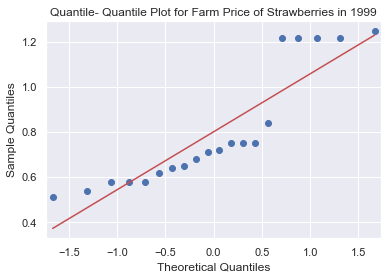

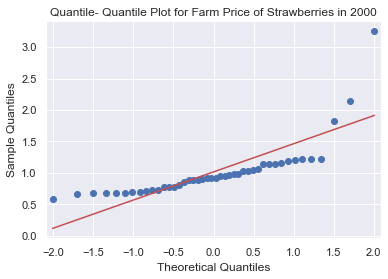

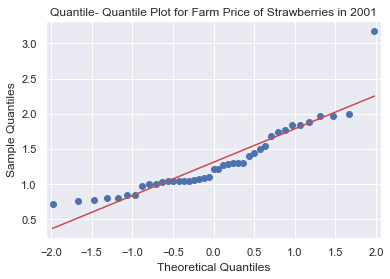

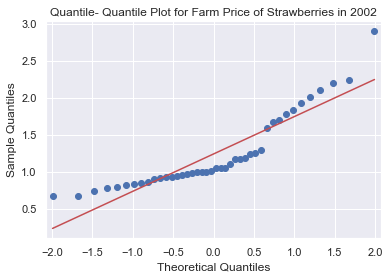

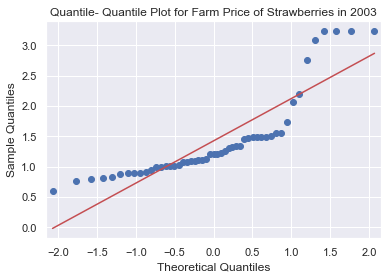

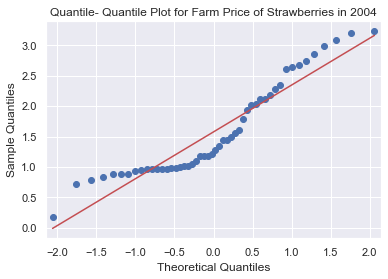

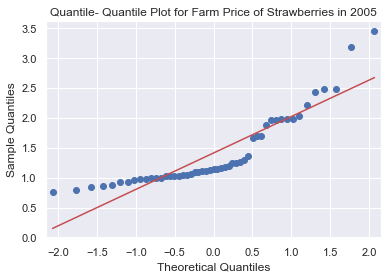

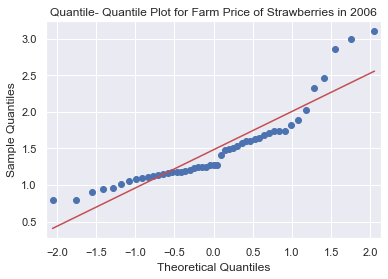

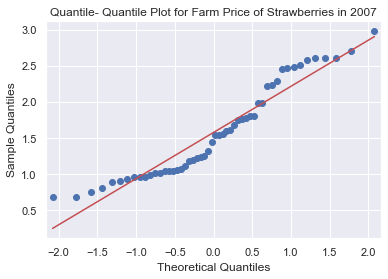

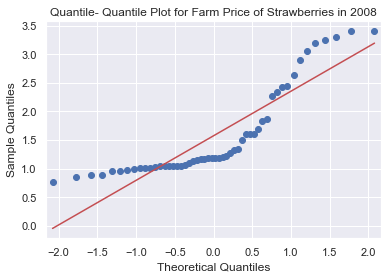

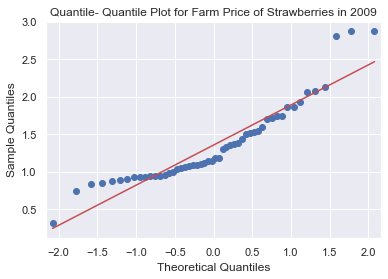

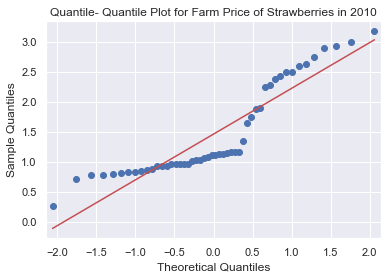

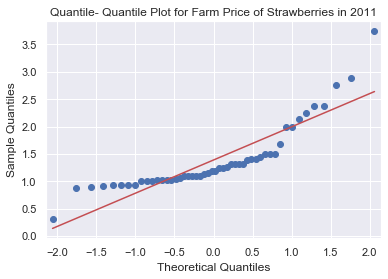

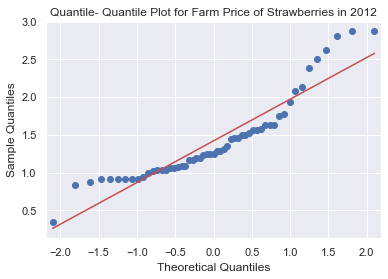

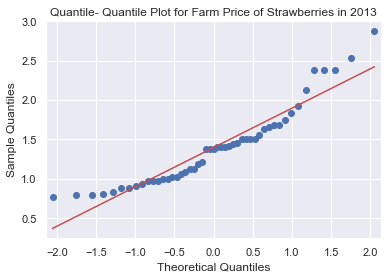

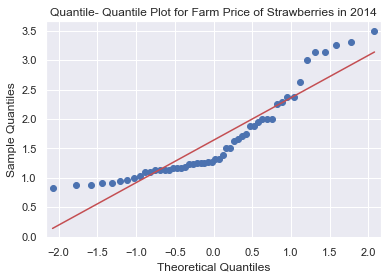

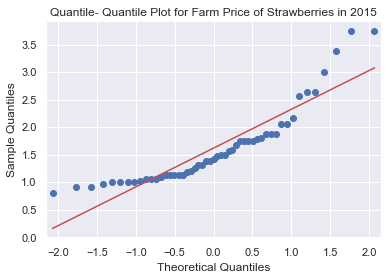

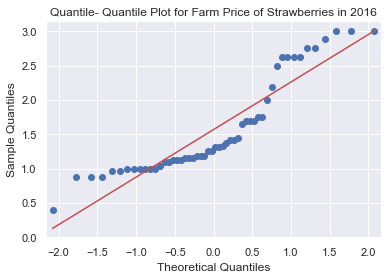

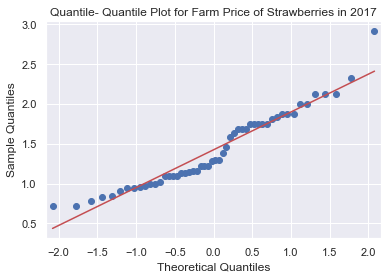

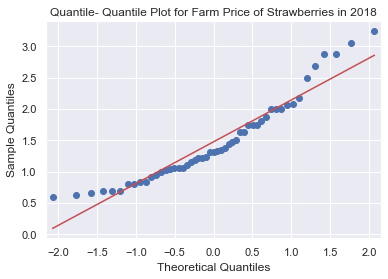

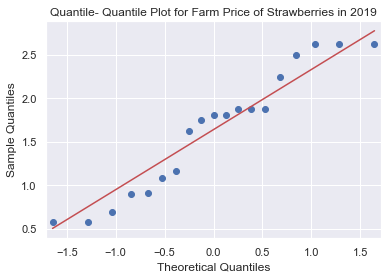

In [93]:
from statsmodels.graphics.gofplots import qqplot
for year in years:
    data = produce_dict['Strawberries'][produce_dict['Strawberries'].index.year == year]['Farm Price']
    qqplot(data, line='s')
    plt.title(f'Quantile- Quantile Plot for Farm Price of Strawberries in {year}')
    plt.show()

1999 looks approximately normal until the giant jump right around Z = 0.75. 2019 could be better, but it isn't all that bad either. Will continue on and assume that all sampling distributions from farm pirce by year are normally distributed. Now for the retail prices.

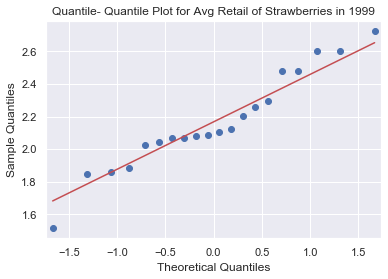

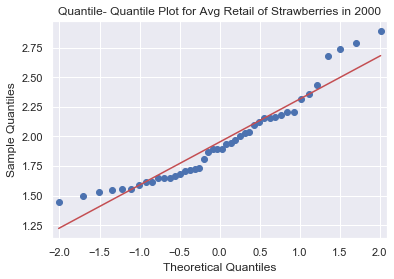

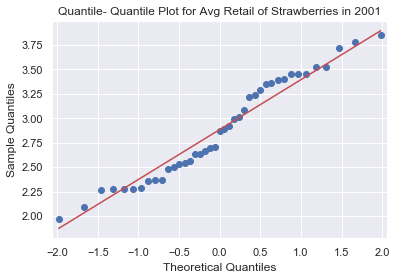

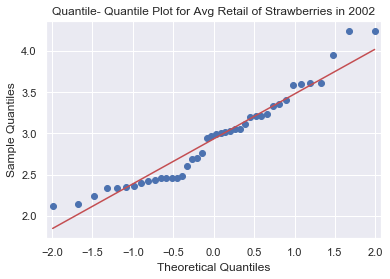

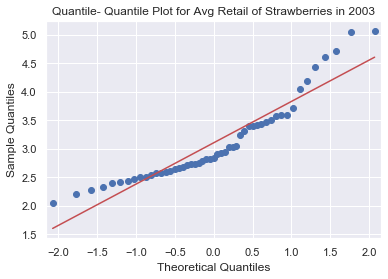

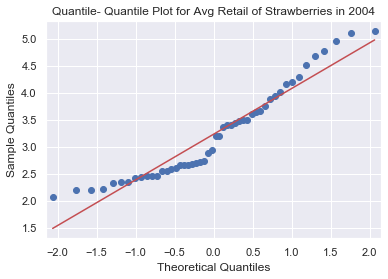

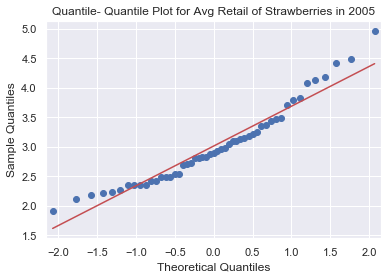

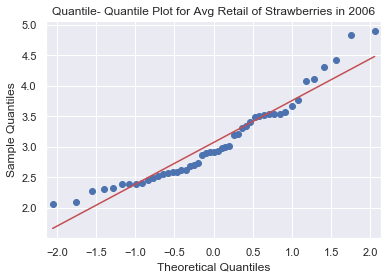

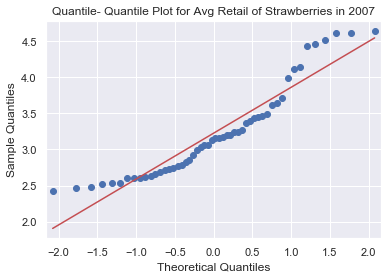

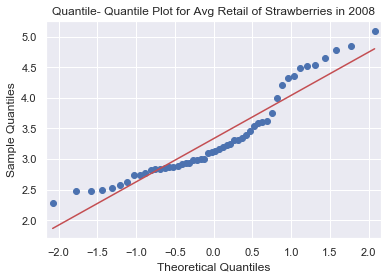

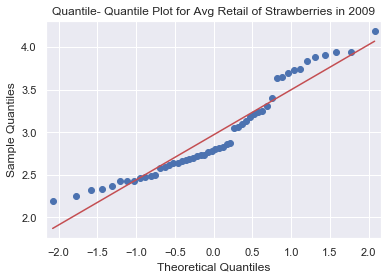

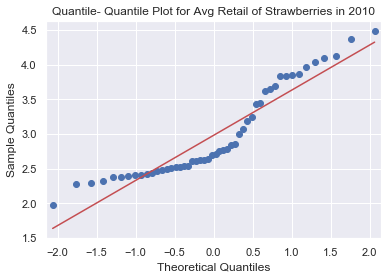

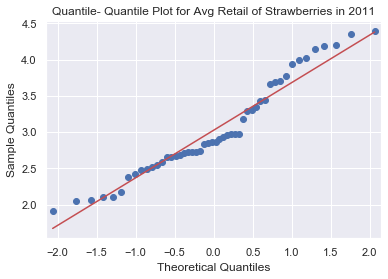

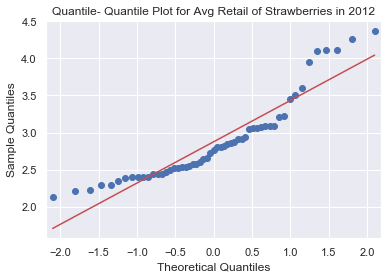

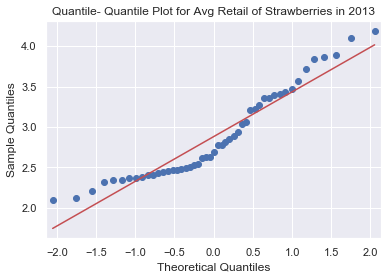

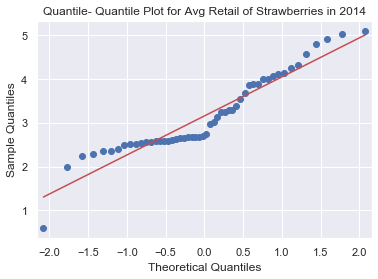

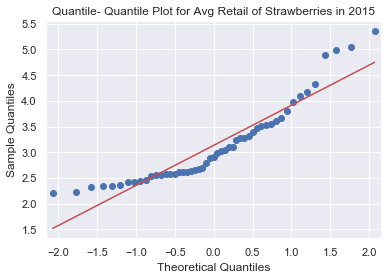

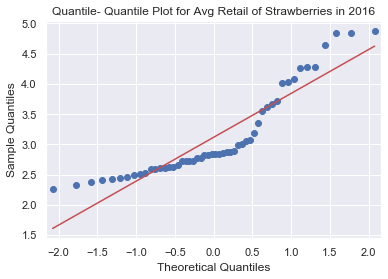

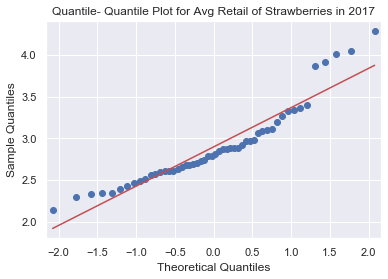

RuntimeError: The data contains non-finite values.

In [100]:
for year in years:
    data = produce_dict['Strawberries'][produce_dict['Strawberries'].index.year == year]['avg_retail']
    qqplot(data, line='s')
    plt.title(f'Quantile- Quantile Plot for Avg Retail of Strawberries in {year}')
    plt.show()

In [105]:
produce_dict['Strawberries'][produce_dict['Strawberries'].index.year == 2018]['avg_retail']

Date
2018-12-30    4.6250
2018-12-23    4.3500
2018-12-16    4.3450
2018-12-09    4.2025
2018-12-02    4.2125
2018-11-25       NaN
2018-11-18    3.6700
2018-11-11    3.4075
2018-11-04    3.2275
2018-10-28    3.1125
2018-10-21    2.9575
2018-10-14    2.9600
2018-10-07    2.7375
2018-09-30    3.0750
2018-09-26    2.7225
2018-09-23    3.0500
2018-09-09    3.0825
2018-09-02    2.5750
2018-08-26    2.9325
2018-08-19    2.8050
2018-08-12    2.7025
2018-08-05    2.7700
2018-07-29    2.8050
2018-07-22    2.5750
2018-07-15    2.7175
2018-07-08    2.2375
2018-07-01    2.4875
2018-06-24    2.3050
2018-06-17    2.4825
2018-06-10    2.4550
2018-06-07    2.5925
2018-06-03    2.4450
2018-05-20    2.3350
2018-05-13    2.3175
2018-05-06    2.3125
2018-04-29    2.8650
2018-04-22    2.8800
2018-04-15    2.7750
2018-04-08    3.3625
2018-04-01    2.9125
2018-03-25    2.9700
2018-03-18    2.7375
2018-03-11    2.5650
2018-02-25    2.6625
2018-02-18    2.5500
2018-02-11    2.9925
2018-02-04    3.2125
2018-01-

# Adjusting for inflation

Adjusting prices for inflation based on month using the consumer price index data found here [https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/](https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/)

Everything will be changed to correspond to USD in 2020

In [32]:
cpi_df = pd.read_csv('../../data/00_raw/cpi.csv', index_col=0, header=1)

In [33]:
cpi_df

,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,Avg,Dec-Dec,Avg-Avg
Year,,,,,,,,,,,,,,,
1913,9.800,9.800,9.800,9.800,9.700,9.800,9.900,9.900,10.000,10.000,10.100,10.000,9.900,–,–
1914,10.000,9.900,9.900,9.800,9.900,9.900,10.000,10.200,10.200,10.100,10.200,10.100,10.000,1,1
1915,10.100,10.000,9.900,10.000,10.100,10.100,10.100,10.100,10.100,10.200,10.300,10.300,10.100,2,1
1916,10.400,10.400,10.500,10.600,10.700,10.800,10.800,10.900,11.100,11.300,11.500,11.600,10.900,12.6,7.9
1917,11.700,12.000,12.000,12.600,12.800,13.000,12.800,13.000,13.300,13.500,13.500,13.700,12.800,18.1,17.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017,0.7,0.1
2016,236.916,237.111,238.132,239.261,240.236,241.038,240.647,240.853,241.428,241.729,241.353,241.432,240.007,2.1,1.3
2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,245.120,2.1,2.1


# Averaging prices on a monthly basis
It appears that there are between 3 and 5 data points for each month in this data set. Since I have monthly cpi data, it makes sense to average these values on a monthly basis for each year. Variance only really needs to be accounted for for Farm Prices as averaging the retail prices variance should yield the correct variance. The sample size is small, but 

In [39]:
monthly_mean = produce_dict['Strawberries'].resample('M').mean()
monthly_variance = produce_dict['Strawberries'].resample('M').var()


In [45]:
monthly_mean['Farm Price variance'] = monthly_variance.values[:, 0]



In [46]:
monthly_mean

,Farm Price,avg_retail,avg_retail_var,Farm Price variance
Date,,,,
1999-07-31,0.640000,1.512500,1.022492,NaN
1999-08-31,0.682000,2.068000,1.973747,0.004570
1999-09-30,0.647500,2.186250,2.166242,0.006892
1999-10-31,0.652000,1.973000,1.861307,0.019670
1999-11-30,1.220000,2.541250,2.921996,0.000000
...,...,...,...,...
2019-01-31,2.597500,4.114375,0.727490,0.004225
2019-02-28,1.876667,3.213333,0.202639,0.108133
2019-03-31,1.852000,2.914000,0.104463,0.001470


In [38]:
monthly_mean_dict = {}
for item in produce_list:
    monthly_mean = produce_dict[item].resample('M').mean()
    monthly_variance = produce_dict[item].resample('M').var()
    mean_df = 
    monthly_mean_dict.setdefault(item, )

,Farm Price,avg_retail,avg_retail_var
Date,,,
1999-07-31,NaN,NaN,NaN
1999-08-31,0.004570,0.016308,0.048308
1999-09-30,0.006892,0.011873,0.029844
1999-10-31,0.019670,0.010126,0.024708
1999-11-30,0.000000,0.005419,0.022385
...,...,...,...
2019-01-31,0.004225,0.171243,0.050003
2019-02-28,0.108133,0.262865,0.003872
2019-03-31,0.001470,0.024633,0.007862


# Conversion to 2019 dollars
This is going to be a little bit tricky. The objective is to translate all prices in the dataframes to 2019 dollars of the most recent cpi. I have to match the month and year from the index of the produce data frames to the month and year from the cpi data frame and multiply by todays cpi divided by the cpi during that month and year.

First method I can immediately think of is to loop through each dataframe and apply the conversion where the months and year match. This isn't so bad on this dataframe but for large data it would be inefficient. In that case I would start thinking about how you could use arrays to process the data.

In [30]:
produce_dict['Strawberries'].index

DatetimeIndex(['2019-05-19', '2019-05-12', '2019-05-05', '2019-04-28',
               '2019-04-21', '2019-04-14', '2019-04-07', '2019-03-31',
               '2019-03-24', '2019-03-17',
               ...
               '1999-09-26', '1999-09-20', '1999-09-13', '1999-09-06',
               '1999-08-30', '1999-08-23', '1999-08-16', '1999-08-09',
               '1999-08-02', '1999-07-26'],
              dtype='datetime64[ns]', name='Date', length=985, freq=None)

In [42]:
cpi_df.columns[0:13] = list(np.arange(1,13))

TypeError: Index does not support mutable operations